In [1]:
import sys
import os
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath("../src"))
# We change the working directory to the root of the project
# Run this only once
root_path = Path.cwd().parent
os.chdir(root_path)
sys.path.append(root_path / "src")

This notebook is intended to show how to use flow models with stable diffusion. We use the ```diffusers``` library to open the stable diffusion model

In [2]:
from diffusers import StableDiffusionPipeline
import torch

T = 1000  # number of timesteps

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Load the pretrained Stable Diffusion pipeline
pipeline = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", 
    torch_dtype=torch.float16,

).to("cuda")


pipeline.scheduler.set_timesteps(T)

# Get access to the UNet (the noise predictor)
unet = pipeline.unet
scheduler = pipeline.scheduler
tokenizer = pipeline.tokenizer
text_encoder = pipeline.text_encoder

# === Create your conditioning ===
prompt = ["a photo of an astronaut riding a horse"]
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt")
text_input = text_input.to("cuda")
with torch.no_grad():
    text_embeddings = text_encoder(**text_input).last_hidden_state

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
scheduler

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.33.1",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null
}

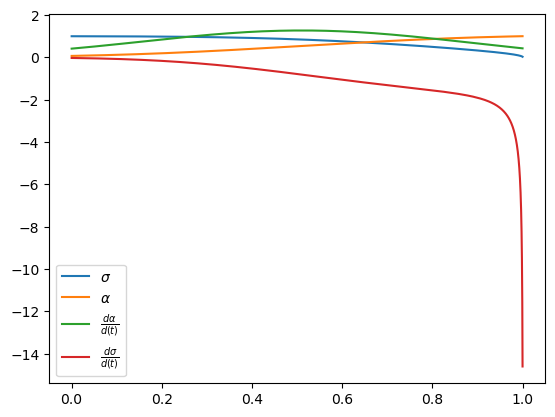

In [3]:
from scipy.interpolate import CubicSpline


def interpolate_alphas_cumprod(t_cont: torch.Tensor, alphas_cumprod: torch.Tensor) -> torch.Tensor:
    """
    Use torch.nn.functional.interpolate to interpolate alphas_cumprod at arbitrary t_cont.
    Args:
        t_cont: Tensor of shape (...,), with values in [0, 1]
        alphas_cumprod: Tensor of shape (T,)
    Returns:
        Tensor of shape (...,)
    """
    # Convert to numpy arrays
    t_cont_np = t_cont.cpu().numpy()
    alphas_cumprod_np = alphas_cumprod.cpu().numpy()

    # Create a cubic spline interpolation of the alphas_cumprod
    cs = CubicSpline(np.linspace(0, 1, len(alphas_cumprod)), alphas_cumprod_np)

    # Interpolate at the given t_cont
    interpolated_values = cs(t_cont_np)

    # Convert back to a tensor
    return torch.tensor(interpolated_values, device=t_cont.device)

def alpha_dt(t_cont: torch.Tensor, alphas_cumprod: torch.Tensor) -> torch.Tensor:
    """
    Compute d/d(1−t) [ α(t) = sqrt( ᾱ(1−t) ) ].
    Args:
        t_cont: Tensor of shape (...,), values in [0,1].
        alphas_cumprod: Tensor of shape (T,).
    Returns:
        dα/d(1−t), same shape as t_cont.
    """
    # to numpy
    t_np = t_cont.cpu().numpy()
    acp = alphas_cumprod.cpu().numpy()
    # build spline for ᾱ(s)
    cs = CubicSpline(np.linspace(0.0, 1.0, acp.shape[0]), acp)
    # evaluate at s = 1−t
    u = 1.0 - t_np
    abar_u = cs(u)
    d_abar_du = cs.derivative()(u)
    # dα/ds = 1/(2√abar) · d_abar_du
    d_alpha = d_abar_du / (2.0 * np.sqrt(abar_u))
    # back to torch
    return torch.tensor(d_alpha, device=t_cont.device, dtype=t_cont.dtype)


def sigma_dt(t_cont: torch.Tensor, alphas_cumprod: torch.Tensor) -> torch.Tensor:
    """
    Compute d/d(1−t) [ σ(t) = sqrt(1 − ᾱ(1−t)) ].
    Args:
        t_cont: Tensor of shape (...,), values in [0,1].
        alphas_cumprod: Tensor of shape (T,).
    Returns:
        dσ/d(1−t), same shape as t_cont.
    """
    # to numpy
    t_np = t_cont.cpu().numpy()
    acp = alphas_cumprod.cpu().numpy()
    # build spline for ᾱ(s)
    cs = CubicSpline(np.linspace(0.0, 1.0, acp.shape[0]), acp)
    # evaluate at s = 1−t
    u = 1.0 - t_np
    abar_u = cs(u)
    d_abar_du = cs.derivative()(u)
    # dσ/ds = d/ds[√(1−abar)] = −d_abar_du / (2√(1−abar))
    d_sigma = -d_abar_du / (2.0 * np.sqrt(1.0 - abar_u))
    # back to torch
    return torch.tensor(d_sigma, device=t_cont.device, dtype=t_cont.dtype)


alpha_bar = lambda t: interpolate_alphas_cumprod(t, scheduler.alphas_cumprod)

sigma = lambda t: torch.sqrt(1 - alpha_bar((1-t)))
alpha = lambda t: torch.sqrt(alpha_bar((1-t)))

alpha_dt_ = lambda t: -alpha_dt(t, scheduler.alphas_cumprod)
sigma_dt_ = lambda t: -sigma_dt(t, scheduler.alphas_cumprod)

t = torch.linspace(0, 1, 5000)
plt.plot(t, sigma(t), label=r"$\sigma$")
plt.plot(t, alpha(t), label=r"$\alpha$")
plt.plot(t, alpha_dt_(t), label=r"$\frac{d\alpha}{d(t)}$")
plt.plot(t, sigma_dt_(t), label=r"$\frac{d\sigma}{d(t)}$")
plt.legend()
# plt.plot(t, alpha_dt_(t))
# plt.plot(t, sigma_dt_(t))
# plt.title("Alpha and Sigma")
# plt.legend(["sigma", "alpha", "alpha_dt", "sigma_dt"])

In [ ]:
def unet_predict(t, x_t):
    T = len(scheduler.alphas_cumprod)

    t = (1-t) * (T-1)
    t = torch.clamp(t, 0, T-1).long()
    t = t.to(x_t.device)
    print(t.max())

    # Get the predicted noise from the UNet
    with torch.no_grad():
        noise_pred = unet(x_t.to(dtype=torch.float16), t, encoder_hidden_states=text_embeddings).sample
    return noise_pred.to(dtype=torch.float32)

/home/mathis/anaconda3/lib/python3.12/site-packages/pytorch_lightning/utilities/parsing.py:209: Attribute 'path' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['path'])`.


tensor(999, device='cuda:0')
tensor(995, device='cuda:0')
tensor(992, device='cuda:0')
tensor(988, device='cuda:0')
tensor(988, device='cuda:0')
tensor(985, device='cuda:0')
tensor(982, device='cuda:0')
tensor(978, device='cuda:0')
tensor(978, device='cuda:0')
tensor(975, device='cuda:0')
tensor(972, device='cuda:0')
tensor(968, device='cuda:0')
tensor(968, device='cuda:0')
tensor(965, device='cuda:0')
tensor(962, device='cuda:0')
tensor(958, device='cuda:0')
tensor(958, device='cuda:0')
tensor(955, device='cuda:0')
tensor(951, device='cuda:0')
tensor(948, device='cuda:0')
tensor(948, device='cuda:0')
tensor(945, device='cuda:0')
tensor(941, device='cuda:0')
tensor(938, device='cuda:0')
tensor(938, device='cuda:0')
tensor(935, device='cuda:0')
tensor(931, device='cuda:0')
tensor(928, device='cuda:0')
tensor(928, device='cuda:0')
tensor(925, device='cuda:0')
tensor(921, device='cuda:0')
tensor(918, device='cuda:0')
tensor(918, device='cuda:0')
tensor(914, device='cuda:0')
tensor(911, de

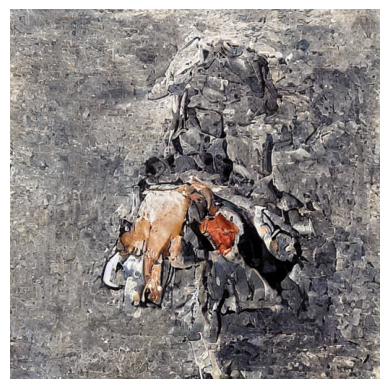

In [34]:
from src.flows.schedulers import CosineScheduler, InterpolatedScheduler
from src.flows.flow import Flow
from src.flows.path import AffinePath
from src.flows.types import FlowConfig
from src.flows.losses import MSEFlowMatchingLoss

# Create the flow matching object
fm_scheduler = InterpolatedScheduler(alphas_cumprod=scheduler.alphas_cumprod)
path = AffinePath(scheduler=fm_scheduler)

cfg = FlowConfig(
    predicts="x0", # the unet predicts the noise
    compile=False
)

flow = Flow(
    path=path,
    loss_fn=MSEFlowMatchingLoss,
    model=unet_predict,
    cfg=cfg
)

latents = torch.randn(1, 4, 64, 64).to("cuda")

# uses midpoint per default for the discretization - two calls per step
latents = flow.sample(latents, n_steps=100, method="rk4")
latents = latents / 0.18215
latents = latents.to(dtype=torch.float16, device='cuda')

# pipeline.vae.to("cpu")

print('Decoding latents')
with torch.no_grad():
    image = pipeline.vae.decode(latents).sample

image = (image / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()
image = (image * 255).round().astype("uint8")
# Plot the image
plt.imshow(image[0])
plt.axis("off")
plt.show()

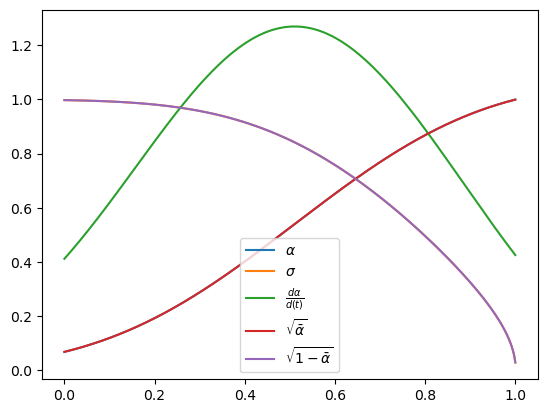

In [30]:
t = torch.linspace(0, 1, 1000)

plt.plot(t, fm_scheduler.alpha(t), label=r"$\alpha$")
plt.plot(t, fm_scheduler.sigma(t), label=r"$\sigma$")
plt.plot(t, fm_scheduler.alpha_dt(t), label=r"$\frac{d\alpha}{d(t)}$")
# plt.plot(t, fm_scheduler.sigma_dt(t), label=r"$\frac{d\sigma}{d(t)}$")
plt.plot(1-t, scheduler.alphas_cumprod**.5, label=r"$\sqrt{\bar{\alpha}}$")
plt.plot(1-t, (1-scheduler.alphas_cumprod)**.5, label=r"$\sqrt{1-\bar{\alpha}}$")
plt.legend()

In [6]:
def epsilon_prediction(t, latents):
    """
    Get the score prediction for given timesteps and latents.
    """
    latents = latents.to(dtype=torch.float16)  # Ensure latents are in float16

    # map t (0-1 float) to the scheduler timesteps (0-999)
    t = ((T - 1) * t).long().to('cuda')  # t ∈ [| 0, 999 |]

    print(f"t: {t.max()}")

    # Get the noise prediction from UNet
    with torch.no_grad():
        noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings).sample
    
    return latents - noise_pred


In [7]:
from flows.flow import Flow
from flows.path import AffinePath
from flows.schedulers import OTScheduler

scheduler = OTScheduler()

path = AffinePath(
    scheduler=scheduler
)

flow = Flow(
    path=path,
    loss_fn=lambda x: torch.mean(x**2),
    model=epsilon_prediction,
    predicts='x_0'
)

TypeError: Flow.__init__() got an unexpected keyword argument 'predicts'

In [ ]:
output = flow.sample(x_0=latents)

/home/mathis/anaconda3/lib/python3.12/site-packages/torchdiffeq/_impl/misc.py:306: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


t: 0
t: 10
t: 20
t: 30
t: 40
t: 50
t: 61
t: 71
t: 81
t: 91
t: 101
t: 112
t: 122
t: 132
t: 142
t: 152
t: 163
t: 173
t: 183
t: 193
t: 203
t: 214
t: 224
t: 234
t: 244
t: 254
t: 265
t: 275
t: 285
t: 295
t: 305
t: 316
t: 326
t: 336
t: 346
t: 356
t: 366
t: 377
t: 387
t: 397
t: 407
t: 417
t: 428
t: 438
t: 448
t: 458
t: 468
t: 479
t: 489
t: 499
t: 509
t: 519
t: 530
t: 540
t: 550
t: 560
t: 570
t: 581
t: 591
t: 601
t: 611
t: 621
t: 632
t: 642
t: 652
t: 662
t: 672
t: 682
t: 693
t: 703
t: 713
t: 723
t: 733
t: 744
t: 754
t: 764
t: 774
t: 784
t: 795
t: 805
t: 815
t: 825
t: 835
t: 846
t: 856
t: 866
t: 876
t: 886
t: 897
t: 907
t: 917
t: 927
t: 937
t: 948
t: 958
t: 968
t: 978
t: 988


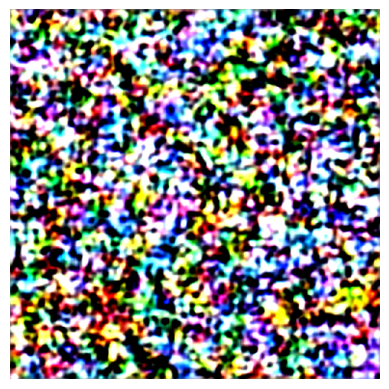

In [ ]:
latents = 1 / 0.18215 * output  # Scale back from latent space
with torch.no_grad():
    image = pipeline.vae.decode(latents).sample  # shape: (bs, 3, 512, 512)

# Normalize to [0, 1] and move to CPU
image = (image.clamp(-1, 1) + 1) / 2  # [0, 1]
image = image.cpu().permute(0, 2, 3, 1).numpy()  # (bs, H, W, C)

import matplotlib.pyplot as plt

plt.imshow(image[0].astype(np.float32))
plt.axis("off")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-198.125..187.0].


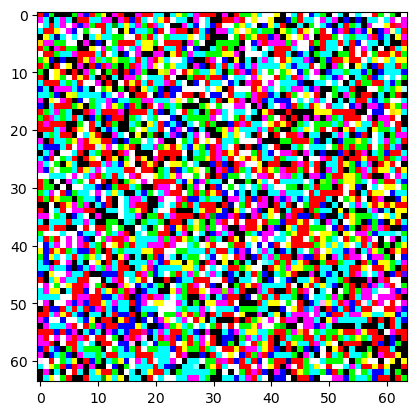

In [ ]:
plt.imshow(output[0].cpu()[1:].permute(1, 2, 0).numpy().astype(np.float32))